In [2]:
import sys
import os

# Obtener la ruta al directorio padre
root = os.path.abspath(r'..\..')

# Agregar la ruta al sys.path para que Python busque en el directorio padre
sys.path.append(root)

import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import LoadDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
###* Load the dataset
dataset = LoadDataset('positions_dynamics.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [4]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for letter in h5file.keys():
        positions = h5file[letter]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([letter]*positions.shape[0]) # extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(2002,)

In [5]:
labels_letter

array(['23', '23', '23', ..., 'YO', 'YO', 'YO'], dtype='<U12')

In [6]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (200, 30, 84)
Data shape 1 (200, 30, 84)
Data shape 2 (199, 30, 84)
Data shape 3 (200, 30, 84)
Data shape 4 (200, 30, 84)
Data shape 5 (200, 30, 84)
Data shape 6 (200, 30, 84)
Data shape 7 (200, 30, 84)
Data shape 8 (201, 30, 84)
Data shape 9 (202, 30, 84)


#### Remember   m -> number of samples, Tx -> frames,  features -> 21*4 (positions in x and y)  

In [7]:
label_encoder = LabelEncoder() ###* LETTERS TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 10


(2002,)

In [8]:
labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [9]:
label_encoder.classes_

array(['23', 'BUENO', 'HOLA', 'MAL', 'NO', 'NOMBRE', 'QUETALL', 'SI',
       'VEINTICUATRO', 'YO'], dtype='<U12')

### For every sample m we have one label

In [10]:
data = np.concatenate(data_h5,axis=0)
data.shape

(2002, 30, 84)

#### sklearn needs data.shape = (m, Tx, nx), where:
#### m is the number of samples
#### Tx is the number of sequences (frames in this case)
#### nx number of featues (positions in this case)

In [11]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.4)

In [12]:
X_train.shape, y_train.shape, X.shape, Y.shape

((1201, 30, 84), (1201,), (801, 30, 84), (801,))

In [13]:
y_train

array([2, 4, 5, ..., 9, 1, 3], dtype=int64)

#### Now we have our train dataset but we need a dev and test dataset

In [14]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [15]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 1201 samples
Dev set: 400 samples
Test set: 401 samples


##### We have 60% for training and 40% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [16]:
# # Crear el escalador y ajustar a los datos de entrenamiento
# from sklearn.preprocessing import MinMaxScaler
# # Reestructurar para agrupar todas las muestras y timesteps
# X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (m*t, features)
# X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
# X_dev_reshaped = X_dev.reshape(-1, X_dev.shape[-1])

# # Crear y ajustar el escalador con los datos de entrenamiento
# scaler = MinMaxScaler()
# X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)

# # Transformar los datos de prueba y validación con el mismo escalador
# X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
# X_dev_scaled_reshaped = scaler.transform(X_dev_reshaped)

# # Restaurar la forma original
# X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
# X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)
# X_dev_scaled = X_dev_scaled_reshaped.reshape(X_dev.shape)

# # Imprimir formas como verificación
# print("X_train escalado:", X_train_scaled.shape)
# print("X_test escalado:", X_test_scaled.shape)
# print("X_dev escalado:", X_dev_scaled.shape)


### ONE HOT to create our matrix with labels

In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

((1201, 10), (400, 10), (401, 10))

In [18]:
y_train_onehot.shape

(1201, 10)

In [19]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

8    49
6    45
9    43
7    40
0    40
1    39
4    39
2    39
5    35
3    31
Name: count, dtype: int64


#### Let's to build our Recurrent NEURAL NETWORK

Epoch 1/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 184s 250ms/step - categorical_accuracy: 0.1519 - loss: 2.3421 - val_categorical_accuracy: 0.2300 - val_loss: 2.1121
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - categorical_accuracy: 0.2735 - loss: 2.0179 - val_categorical_accuracy: 0.3400 - val_loss: 1.8706
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - categorical_accuracy: 0.3327 - loss: 1.9410 - val_categorical_accuracy: 0.5975 - val_loss: 1.3571
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - categorical_accuracy: 0.5866 - loss: 1.2916 - val_categorical_accuracy: 0.7175 - val_loss: 0.9629
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - categorical_accuracy: 0.6109 - loss: 1.1415 - val_categorical_accuracy: 0.5825 - val_loss: 1.1306
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - categorical_accuracy: 0.6636 - loss: 1.0405 - val_categorical_accuracy: 0.6950 - val_loss: 0.9360
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - categ

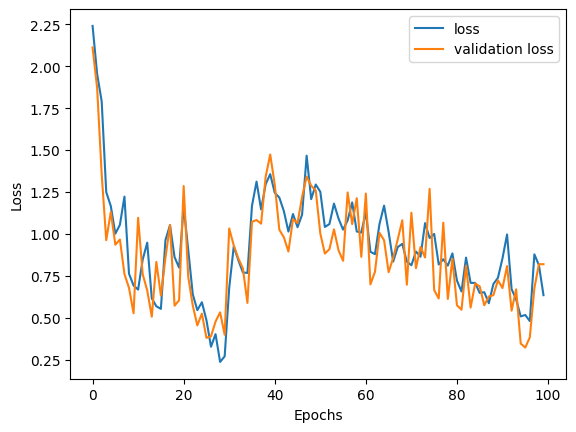

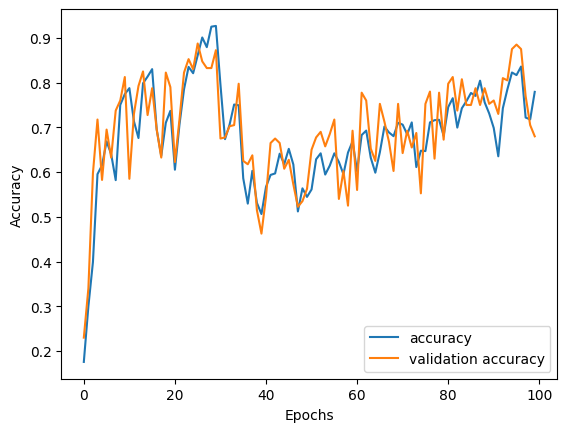

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

Tx = 30
n_classes = 10
n_features = 84

# Define the input layer
inputs = Input(shape=(Tx, n_features))

# First Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu'))(inputs)
x = layers.LayerNormalization()(x)  # Layer normalization

# Second Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu'))(x)
x = layers.LayerNormalization()(x)  # Layer normalization

# Third Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, activation='relu'))(x)
x = layers.LayerNormalization()(x)  # Layer normalization

# Fully connected layers
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)  # Dropout para evitar overfitting
x = layers.Dense(32, activation='relu')(x)

# Output layer
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot,
                    epochs=100,
                    batch_size=4,
                    validation_data=(X_dev, y_dev_onehot))

# Plot loss during training
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy during training
plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [27]:
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Acuraccy on test data: {test_acc:.2f}')
print(f'Loss on training data: {test_loss:.2f}')

******************************************************************************************************************************************************
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.8620 - loss: 0.4088
Acuraccy on test data: 0.89
Loss on training data: 0.35


In [ ]:
n = 5
c_acuracy = history.history['loss'][0::n]
v_acuracy = history.history['val_loss'][0::n]
epocas = np.arange(1, len(history.history['loss']) + 1, n)


Text(0, 0.5, 'Categorical Accuracy')

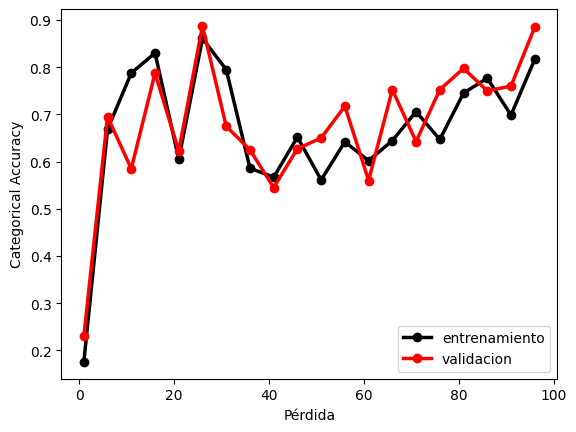

In [32]:
plt.plot(epocas,c_acuracy, label='entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas,v_acuracy, label='validacion', color='red', linewidth=2.5, linestyle='-', marker='o')
plt.legend()

plt.xlabel('Pérdida')
plt.ylabel('Categorical Accuracy')
# plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_dinamicas.pdf')


### Confusion matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step


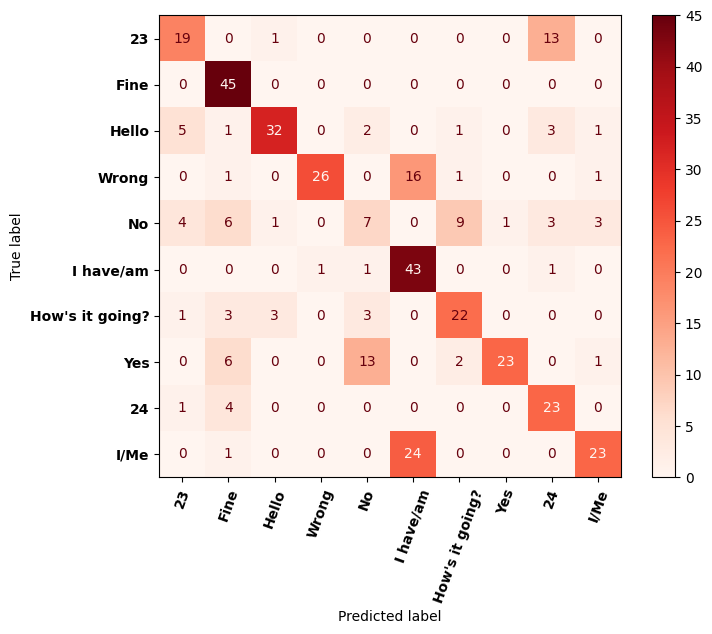

Categorical Accuracy: 0.6559
Accuracy per class: [0.57575758 1.         0.71111111 0.57777778 0.20588235 0.93478261
 0.6875     0.51111111 0.82142857 0.47916667]


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predicciones del modelo
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Predicciones
valores = np.array(['23', 'Fine', 'Hello', 'Wrong', 'No','I have/am', 'How\'s it going?', 'Yes', '24', 'I/Me' ])
# Verdaderos valores
y_true_class = np.argmax(y_test_onehot, axis=1)  # Valores reales

# Matriz de confusión
cm = confusion_matrix(y_true_class, y_pred)

# Crear el display de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valores)

# Plot con ajustes
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Reds', xticks_rotation='vertical', ax=ax)

# Poner en negrita las etiquetas de los ejes X y Y
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=10)

# Ajustar la transparencia
for text in ax.texts:
    text.set_alpha(1)  # Ajustar la transparencia
plt.savefig(r'C:\Users\hgera\Downloads\confusion_matrix_dimanics.pdf')
plt.xticks(rotation=70)
plt.show()

# Sumar los valores diagonales (predicciones correctas)
correct_predictions = np.trace(cm)

# Sumar todos los valores de la matriz (total de predicciones)
total_predictions = np.sum(cm)

# Calcular la categorical accuracy
categorical_accuracy = correct_predictions / total_predictions

print(f'Categorical Accuracy: {categorical_accuracy:.4f}')
# Precisión por clase
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("Accuracy per class:", accuracy_per_class)


In [23]:
asa

NameError: name 'asa' is not defined

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Clase 23: AUC = 0.9801548089591569
Clase BUENO: AUC = 1.0
Clase HOLA: AUC = 0.997940074906367
Clase MAL: AUC = 0.9943820224719101
Clase NO: AUC = 0.9597691937810546
Clase NOMBRE: AUC = 0.9905082669932639
Clase QUETALL: AUC = 0.9926321138211383
Clase SI: AUC = 0.9920099875156055
Clase VEINTICUATRO: AUC = 0.9982765224052087
Clase YO: AUC = 0.997639282341832


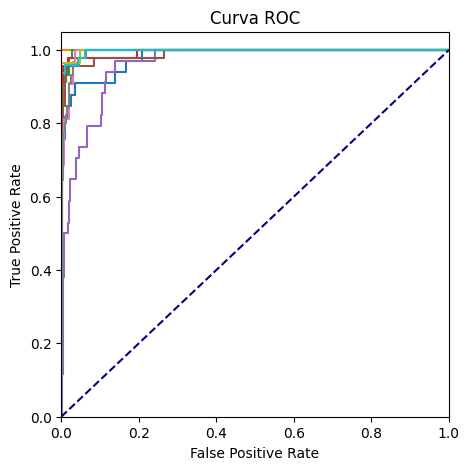

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
y_pred = model.predict(X_test)
num_classes = y_train_onehot.shape[1]
best_thresholds = np.zeros(num_classes)

plt.figure(figsize=(5, 5))

#### Calculate ROC curve and ROC area for each class
for i in range(num_classes):
    y_true_binary = (y_true_class == i).astype(int)
    # print(y_true_binary)
    #### Compute ROC curve and ROC area
    fpr, tpr, threshold = roc_curve(y_true_binary, y_pred[:,i])
    #### Calcualte Youden's J statistic
    J = tpr - fpr
    best_threshold = threshold[np.argmax(J)]
    best_thresholds[i] = best_threshold
    
    # print(f'Clase {i}: Best treshold = {best_threshold}')
    
    
    
    ### Calcular el área bajo la curva ROC
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]}')
    print(f'Clase {label_encoder.classes_[i]}: AUC = {roc_auc}')
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\roc_dinamicas.pdf')

# plt.legend(loc="lower right")
plt.show()



# print('Optimized Tresholds per class ',best_thresholds)

In [24]:
# # * Save the model
path_save = '..\\..\\models\\Trained\\sign\\dynamic_model_all.h5'
# model.save(path_save)

In [25]:
model = tf.keras.models.load_model(path_save)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 84)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       218,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026,988 (3.92 MB)

 Trainable params: 1,026,986 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)